# Physics 113 Final Project

## Approach

https://www.youtube.com/watch?v=evYU6nGXIY4

- Math background
    - FFTs
        - Why FFts don't work for time series
    - STFT
        - Discussion of windowing functions
    - Constant Q transform?
- Music background
    - How to get notes from signals

## Goal

The goal of this project is to automatically transcribe an audio file into musical notation.
This is useful because transcription is a long manual process and many songs don't have sheet music.
This topic has been researched since the 1970s and is an interesting area of study.
This notebook will be structured in a way that incrementally introduces concepts to get to the finished final product.

https://www.eecs.qmul.ac.uk/~simond/pub/2018/BenetosDixonDuanEwert-SPM2018-Transcription.pdf

## Setup

In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy
from scipy.fftpack import fft, fftfreq
from scipy.signal import stft, spectrogram
from scipy.io import wavfile
import numpy as np
import librosa
import librosa.display
import abjad
import music21
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
filename = "./final_project/sound_files/entertainer.wav"
sampling_freq, data = wavfile.read(filename)
print ("# channels: ", len(data.shape))
print ("sampling freq: ", sampling_freq)
if len(data.shape) == 2:
    data = data.sum(axis=1) / 2
n_seconds = 10
data = data[:sampling_freq * n_seconds]

# channels:  2
sampling freq:  48000


In [3]:
ipd.Audio(data, rate=sampling_freq)

In [4]:
N = len(data)
print("N:", N)
secs = N / sampling_freq
print("secs:", secs)
t_step = 1.0 / sampling_freq  # time between samples in seconds
print ("timestep between samples:", t_step)

N: 480000
secs: 10.0
timestep between samples: 2.0833333333333333e-05


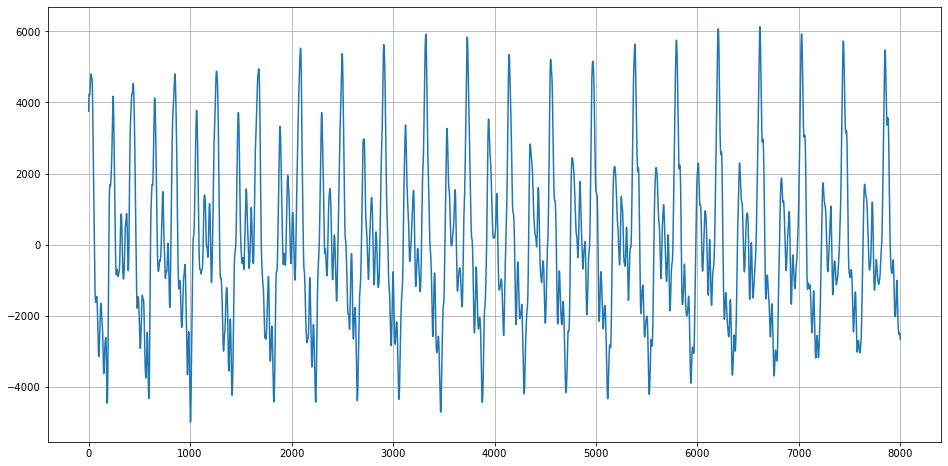

In [5]:
plt.plot(data[9*48000:10*48000-40000])
plt.grid()
plt.show()

## Discrete Fourier Transform

The first step for automatic music transcription is to extract the pitches from a song.
In order to do this, we need to use the discrete Fourier transform (DFT).
Let our signal be defined as a sequence of $N$ samples $x_0,x_1,...,x_{N-1}$.
We define the DFT as:
\begin{equation}
    X(k)=\sum_{t=0}^{N-1} x_t \cdot e^{-\frac{2\pi i}{N} k t},
\end{equation}
where $X(k)$ is the output, and $0\leq k\leq N-1$.

We can see that this is a natural discretization of the Fourier transform,
\begin{equation}
    F(k)=\int_{-\infty}^{\infty} f(t)\cdot e^{-2\pi i k t} dt.
\end{equation}

Furthermore, the coefficients for the Fourier tranform of a function that is nonzero in the interval $[0, $N$]$ is:
\begin{equation}
    c_k=\frac{1}{N}\int_0^{N}f(t)\cdot e^{-\frac{2\pi i}{N} k t} dt,
\end{equation}
which is identical to the DFT equation up to a scaling factor (and the discretization).

References:
- http://musicweb.ucsd.edu/~trsmyth/digitalAudio/digitalAudio.pdf
- https://en.wikipedia.org/wiki/Discrete_Fourier_transform

If we apply the discrete Fourier transform to the raw audio signal, we get the following plot:

In [6]:
fft_out = np.abs(fft(data))
fft_out_side = fft_out[:int(N/2)]
freqs = fftfreq(N, t_step)
freqs_side = freqs[:int(N/2)]
fft_out[:10]

array([207717.        , 375488.01399667, 483763.50905393, 286291.76010865,
       210998.58660455, 478827.03009625, 444602.73544736, 496008.78458241,
       440843.81160059, 293695.62528134])

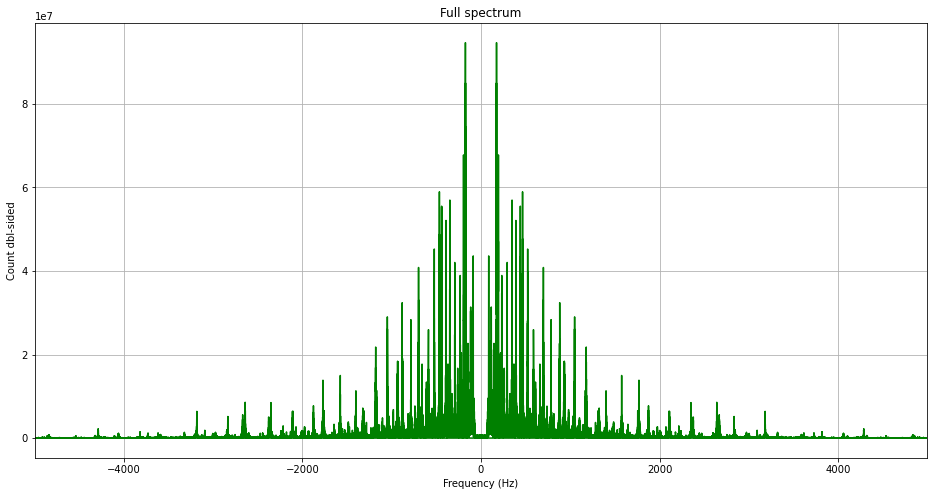

In [7]:
plt.plot(freqs, fft_out, "g")
plt.xlim([-5000, 5000])
plt.title("Full spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count dbl-sided")
plt.grid()
plt.show()

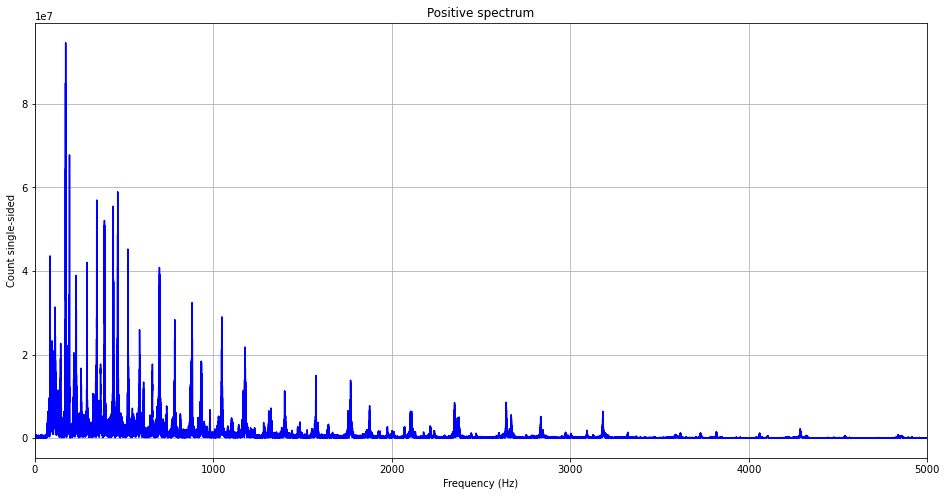

In [8]:
plt.plot(freqs_side, fft_out_side, "b")
plt.xlim([0, 5000])
plt.title("Positive spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count single-sided")
plt.grid()
plt.show()

We can see that the signal contains many frequencies.
This plot is not very useful for automatic transcription.
The question then is: how can we parse these frequencies over time?

## Short-time Fourier Transform (STFT)

The solution to this problem of finding frequencies over time is to use the short-time Fourier Transform (STFT).
For the STFT, the data to be transformed is broken up into chunks that usually overlap each other.
Each chunk is then Fourier transformed.
Furthermore, each chunk is multiplied by a window function.
Therefore, the output of the STFT is two dimensional since the Fourier transform is applied at many intervals throughout the signal.

Formally, the STFT is defined as,
\begin{equation}
    X(k, m)=\sum_{t=0}^{N-1} x_{t} \cdot w(t-m) \cdot e^{-\frac{2\pi i}{N} k t},
\end{equation}
where $X(k, m)$ is the output, $0\leq k\leq N-1$ and $0\leq m\leq N-1$.
Also, $w$ is the window function that must be defined for the domain $[-N+1, N-1]$.

The following image is a diagram of the STFT.
Note the Gaussian-shaped window function.
![STFT image](pictures/stft.jpg)

References:
- https://en.wikipedia.org/wiki/Short-time_Fourier_transform
- https://www.sciencedirect.com/book/9780123744906/digital-signal-processing-system-design
- http://faculty.nps.edu/rcristi/eo3404/b-discrete-fourier-transform/text/3-stft.pdf

For the STFT, we can try different window functions. Two window functions we will consider are boxcar and hann. 

In [9]:
fft_window_len = 1024
overlap = 0.5
hop_length = int(fft_window_len * (1 - overlap))
ylims = [librosa.note_to_hz("B1"), librosa.note_to_hz("B7")]
n_bins=100

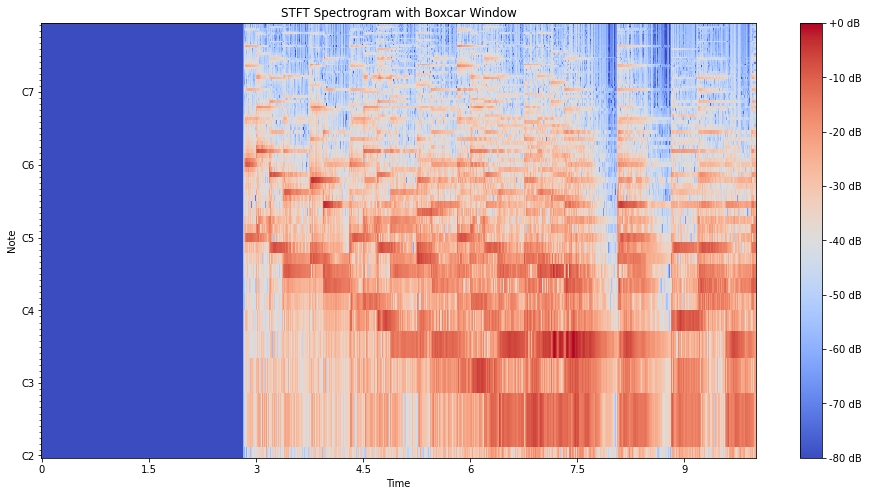

In [10]:
S = librosa.stft(data, n_fft=fft_window_len, hop_length=hop_length, window=scipy.signal.windows.boxcar)
Sdb = librosa.amplitude_to_db(np.abs(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(Sdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="fft_note", ax=ax, cmap="coolwarm")
ax.set_title("STFT Spectrogram with Boxcar Window")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

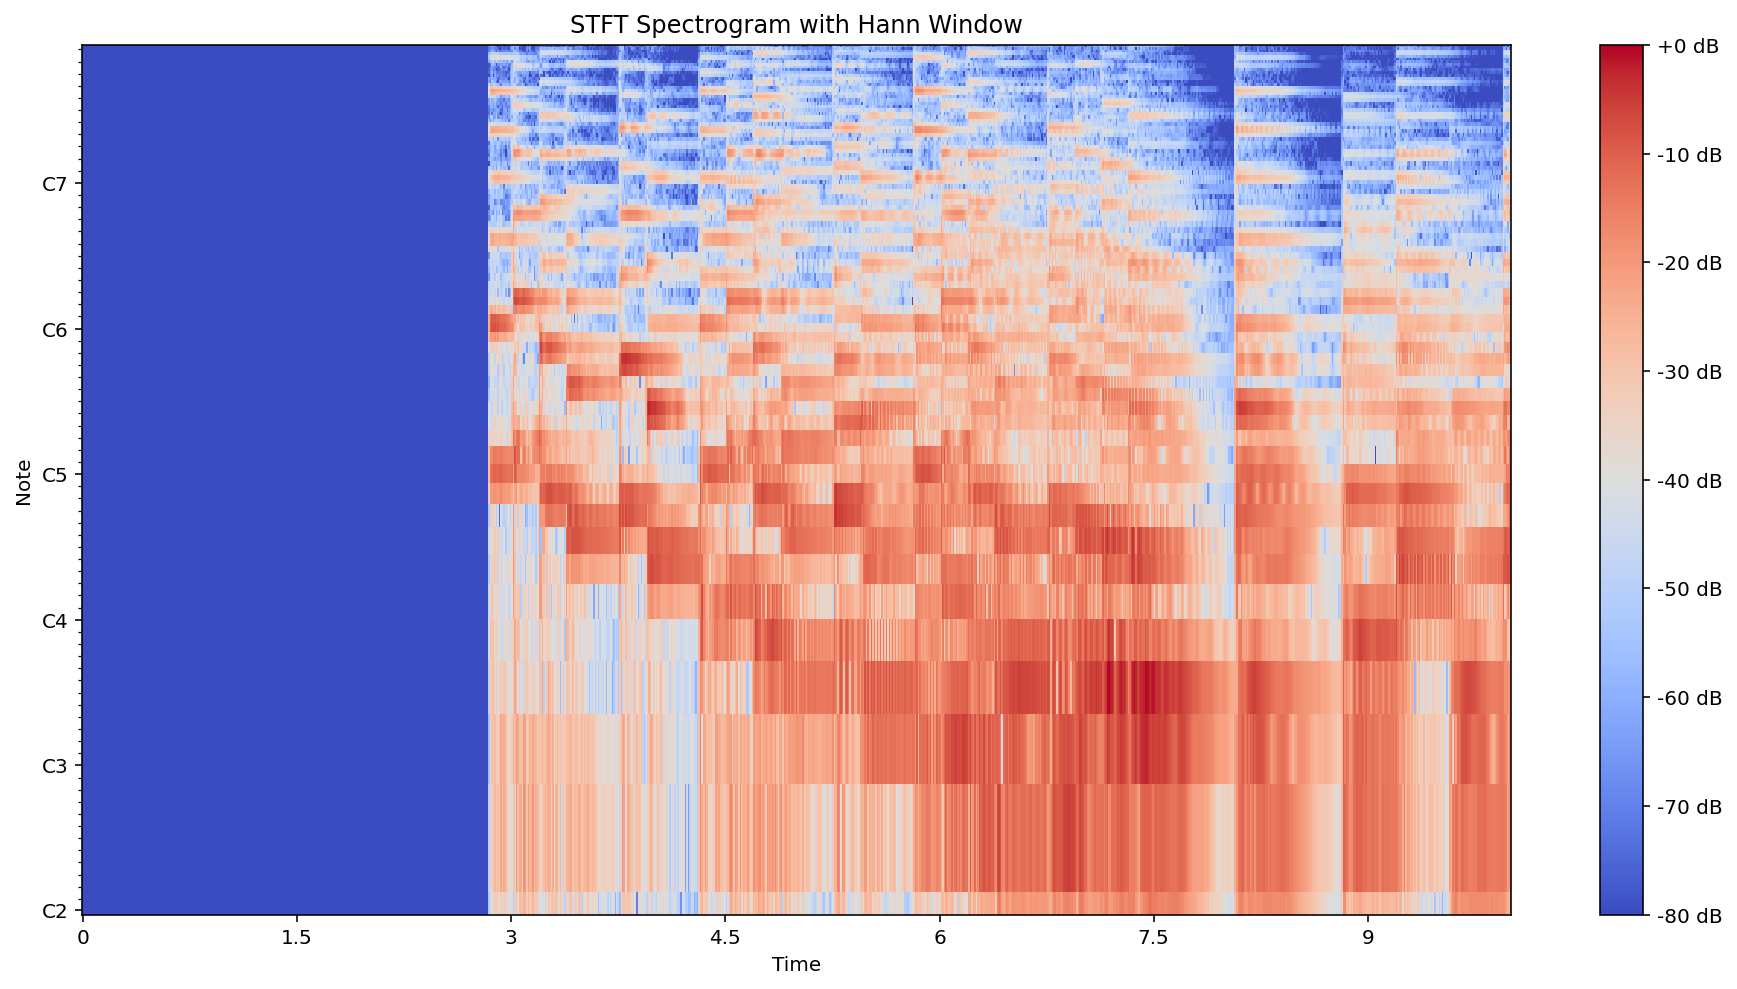

In [11]:
S = librosa.stft(data, n_fft=fft_window_len, hop_length=hop_length, window=scipy.signal.windows.hann)
Sdb = librosa.amplitude_to_db(np.abs(S), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(Sdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="fft_note", ax=ax, cmap="coolwarm")
ax.set_title("STFT Spectrogram with Hann Window")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

## Music Primer

The above part of the notebook was pretty general--we were simply looking at converting a signal into the frequency domain using Fourier transforms.
The next parts of the notebook will require some understanding of how (Western) music is structured.
In the Western music system, notes that are an _octave_ apart are given the same letter.
An octave is 

![Piano octave](pictures/keyboard_octave.jpg)

References:
- https://www.ams.jhu.edu/dan-mathofmusic/notes-intervals/

## Constant Q Transform

The constant-Q transform (CQT) is similar to the STFT in the sense that it maps a signal into the frequency domain.
The main difference is that the CQT has filters logarithmically spaced in frequency as opposed to linear spaced filters in the STFT.
Formally, the width of the $k$th filter $\delta f_k$ is
\begin{equation}
    \delta f_k=2^{1/n} \cdot \delta f_{k-1} = \left(2^{1/n}\right)^k \cdot \delta f_0,
\end{equation}
where $n$ is the number of bins in an octave and $f_0$ is the first frequency bin.


References:
- https://en.wikipedia.org/wiki/Constant-Q_transform
TODO: Explanation

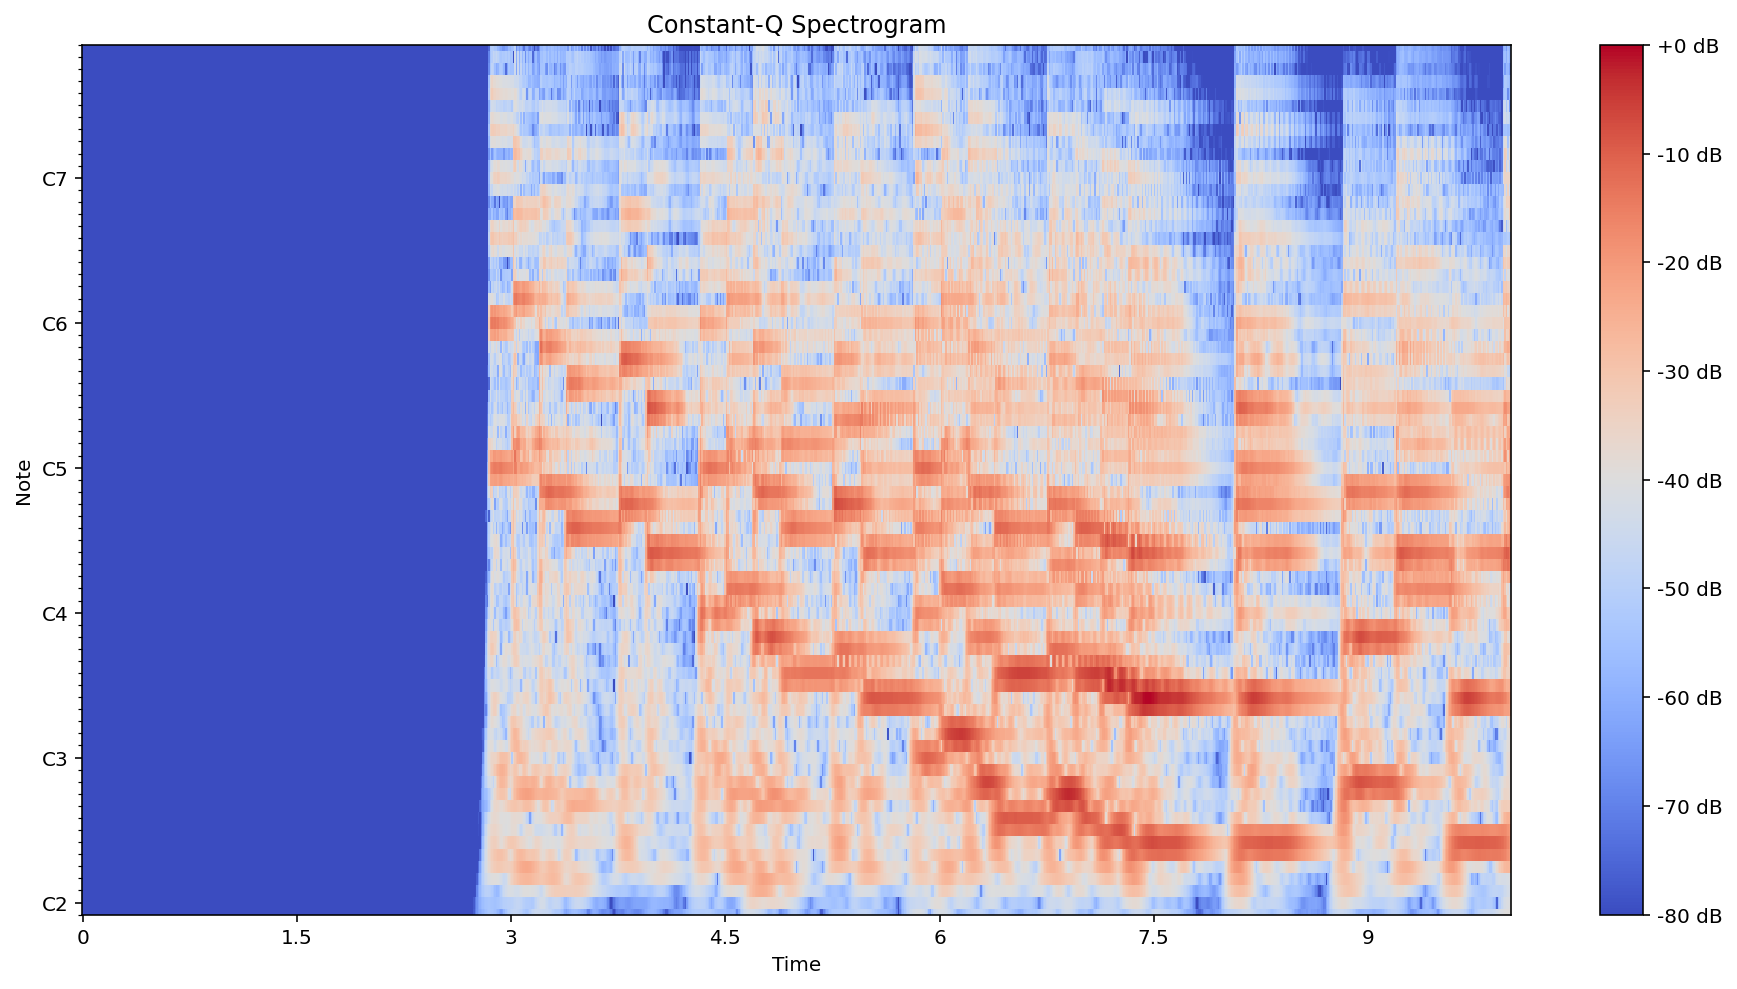

In [12]:
C = librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins)
fig, ax = plt.subplots()
Cdb = librosa.amplitude_to_db(np.abs(C), ref=np.max)
img = librosa.display.specshow(Cdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="cqt_note", ax=ax, cmap="coolwarm")
ax.set_title("Constant-Q Spectrogram")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

## Note Onset Detection

TODO: explain
- https://librosa.org/doc/main/generated/librosa.onset.onset_detect.html#librosa.onset.onset_detect

In [13]:
onset_strength = librosa.onset.onset_strength(y=data, sr=sampling_freq, hop_length=hop_length)
times = librosa.times_like(onset_strength, sr=sampling_freq)
onset_frames = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                          units='time', onset_envelope=onset_strength)

In [14]:
def filter_onset_frames(frames, raw_frames=[]):
    #mean_diff = 0.1 
    mean_diff = np.mean(np.diff(frames)) * 0.35
    if len(raw_frames) > 0:
        return raw_frames[[True] + list(np.diff(frames) > mean_diff)]
    return frames[[True] + list(np.diff(frames) > mean_diff)]

In [15]:
onset_frames = filter_onset_frames(onset_frames)

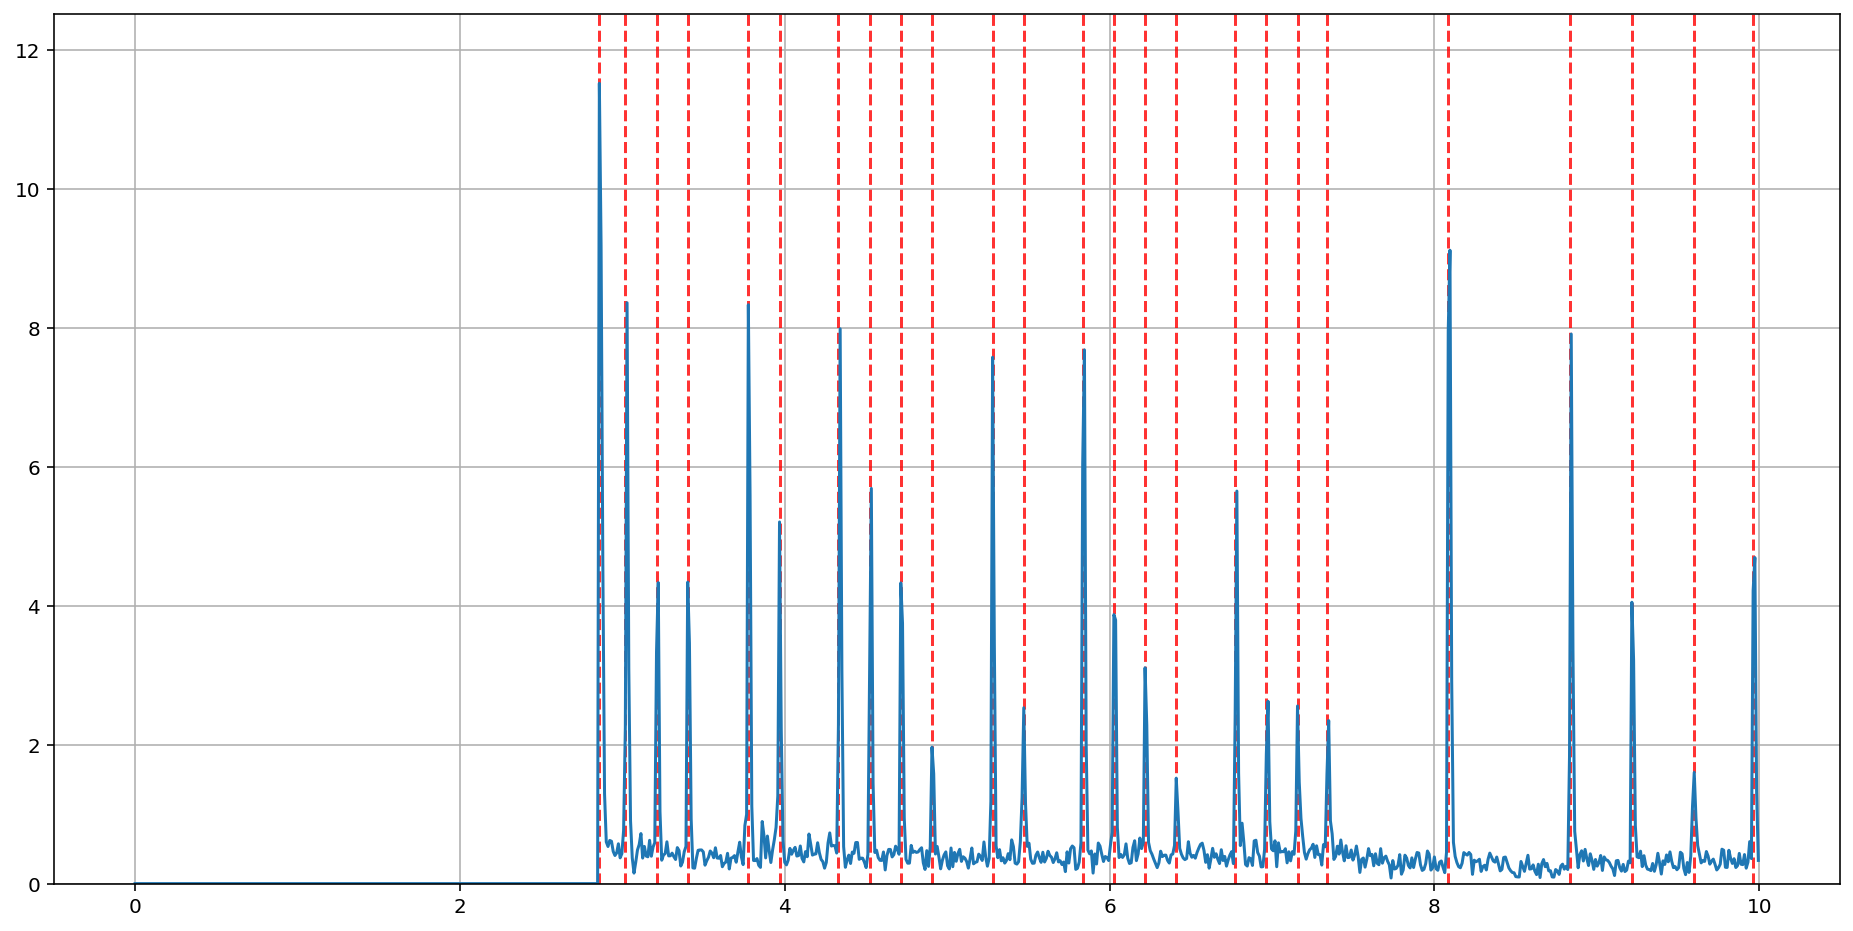

In [16]:
plt.plot(times, onset_strength)
plt.ylim(0, onset_strength.max() + 1)
plt.vlines(onset_frames, 0, onset_strength.max() + 1, color="r", alpha=0.8, linestyle="--")
plt.grid()
plt.show()

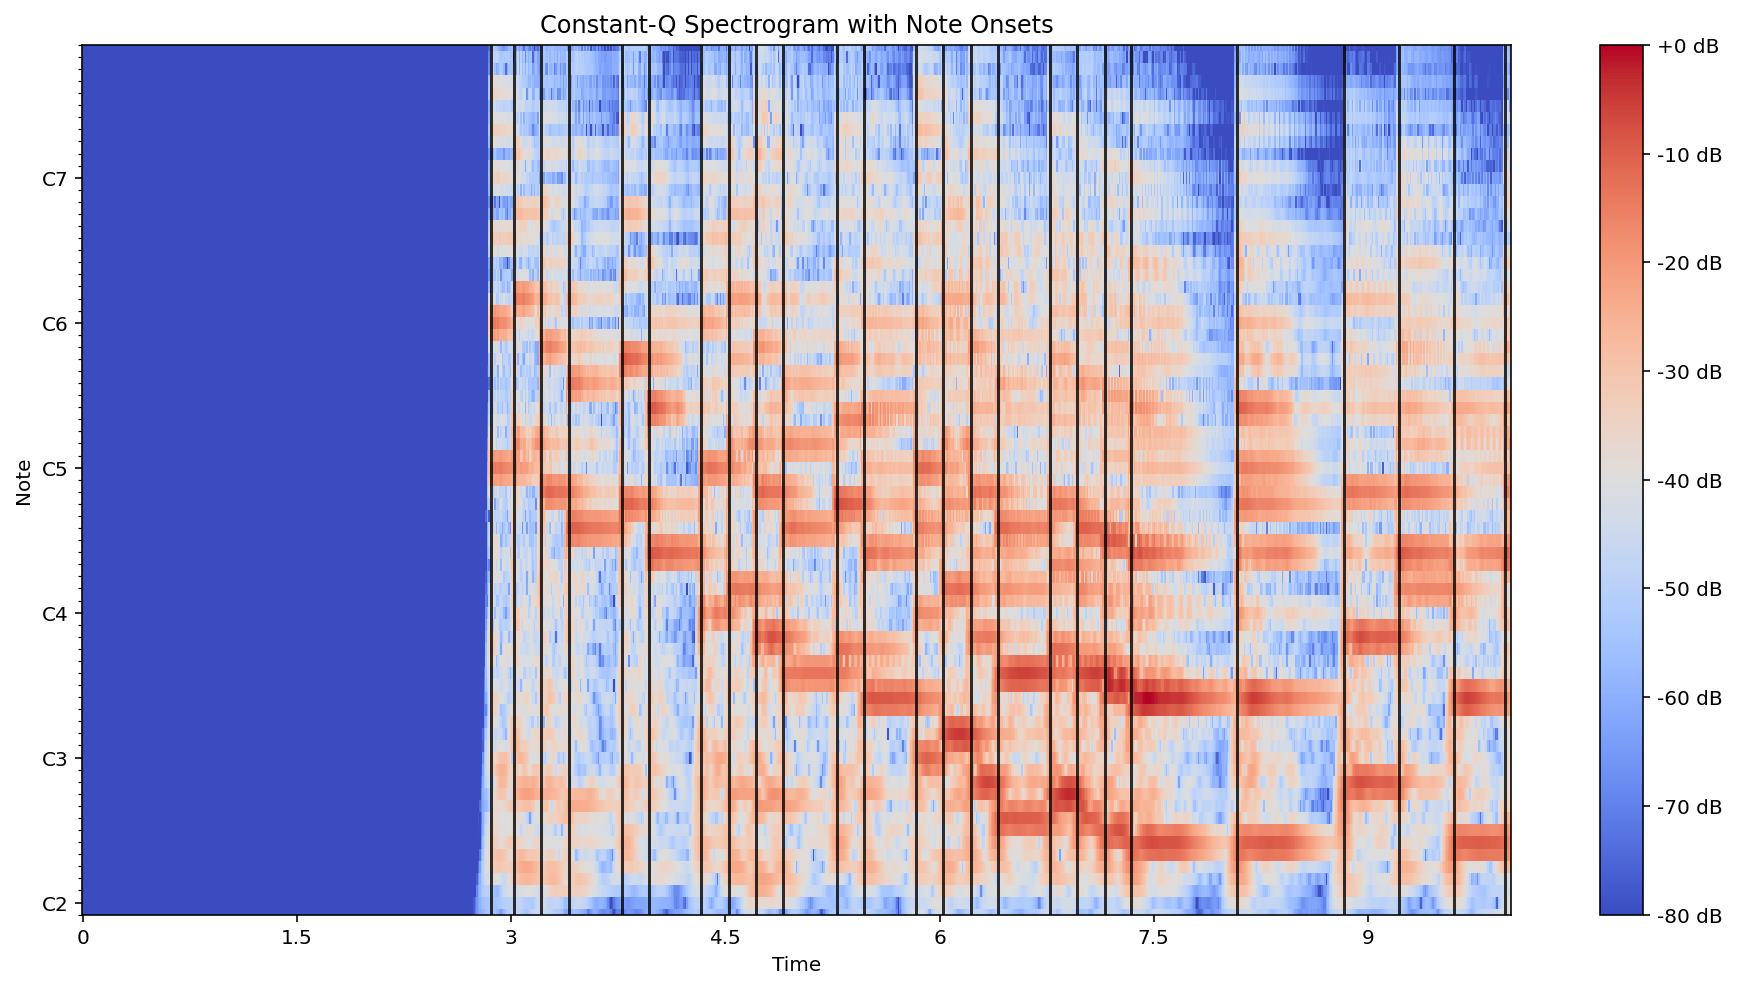

In [17]:
C = librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins)
fig, ax = plt.subplots()
Cdb = librosa.amplitude_to_db(np.abs(C), ref=np.max)
img = librosa.display.specshow(Cdb, sr=sampling_freq, hop_length=hop_length,
                               x_axis="time", y_axis="cqt_note", ax=ax, cmap="coolwarm")
ax.set_title("Constant-Q Spectrogram with Note Onsets")
plt.vlines(onset_frames, ax.get_ylim()[0], ax.get_ylim()[1], color="black", alpha=0.8, linestyle="-")
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.ylim(ylims)
plt.show()

Now, we extract the pitches and corresponding notes at each onset location.

In [18]:
onset_frames_raw = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='frames', onset_envelope=onset_strength)
onset_frames_cpy = librosa.onset.onset_detect(y=data, sr=sampling_freq, hop_length=hop_length,
                                              units='time', onset_envelope=onset_strength)
onset_frames_raw = filter_onset_frames(onset_frames_cpy, onset_frames_raw)
assert(len(onset_frames) == len(onset_frames_raw))

In [19]:
# Get frames in the middle of each note
middle_onset_frames = []
for i in range(len(onset_frames_raw) - 1):
    middle_onset_frames.append(int((onset_frames_raw[i] + onset_frames_raw[i + 1]) / 2))
    #middle_onset_frames.append(onset_frames_raw[i] + 5)
middle_onset_frames.append(Cdb.shape[1] - 1)
assert(len(onset_frames) == len(middle_onset_frames))

In [20]:
freqs = librosa.cqt_frequencies(fmin=librosa.note_to_hz("C1"), n_bins=n_bins)

In [21]:
A4 = 440
C0 = A4 * 2 ** (-4.75)
FREQUENCY_RANGE = (15, 8000)
NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def get_note(freq):
    if freq > FREQUENCY_RANGE[1] or freq < FREQUENCY_RANGE[0]: return None
    h = round(12 * np.log2(freq / C0))
    octave = h // 12
    n = h % 12
    return NAMES[n] + str(octave)

In [22]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

def get_valid_freqs(dbs):
    scaled_dbs = (abs(dbs) - np.min(abs(dbs))) / np.max(abs(dbs))
    freqs = np.argwhere(scaled_dbs < 0.05).flatten()
    r = ranges(freqs)
    return [int(np.mean(x)) for x in r]
    return freqs

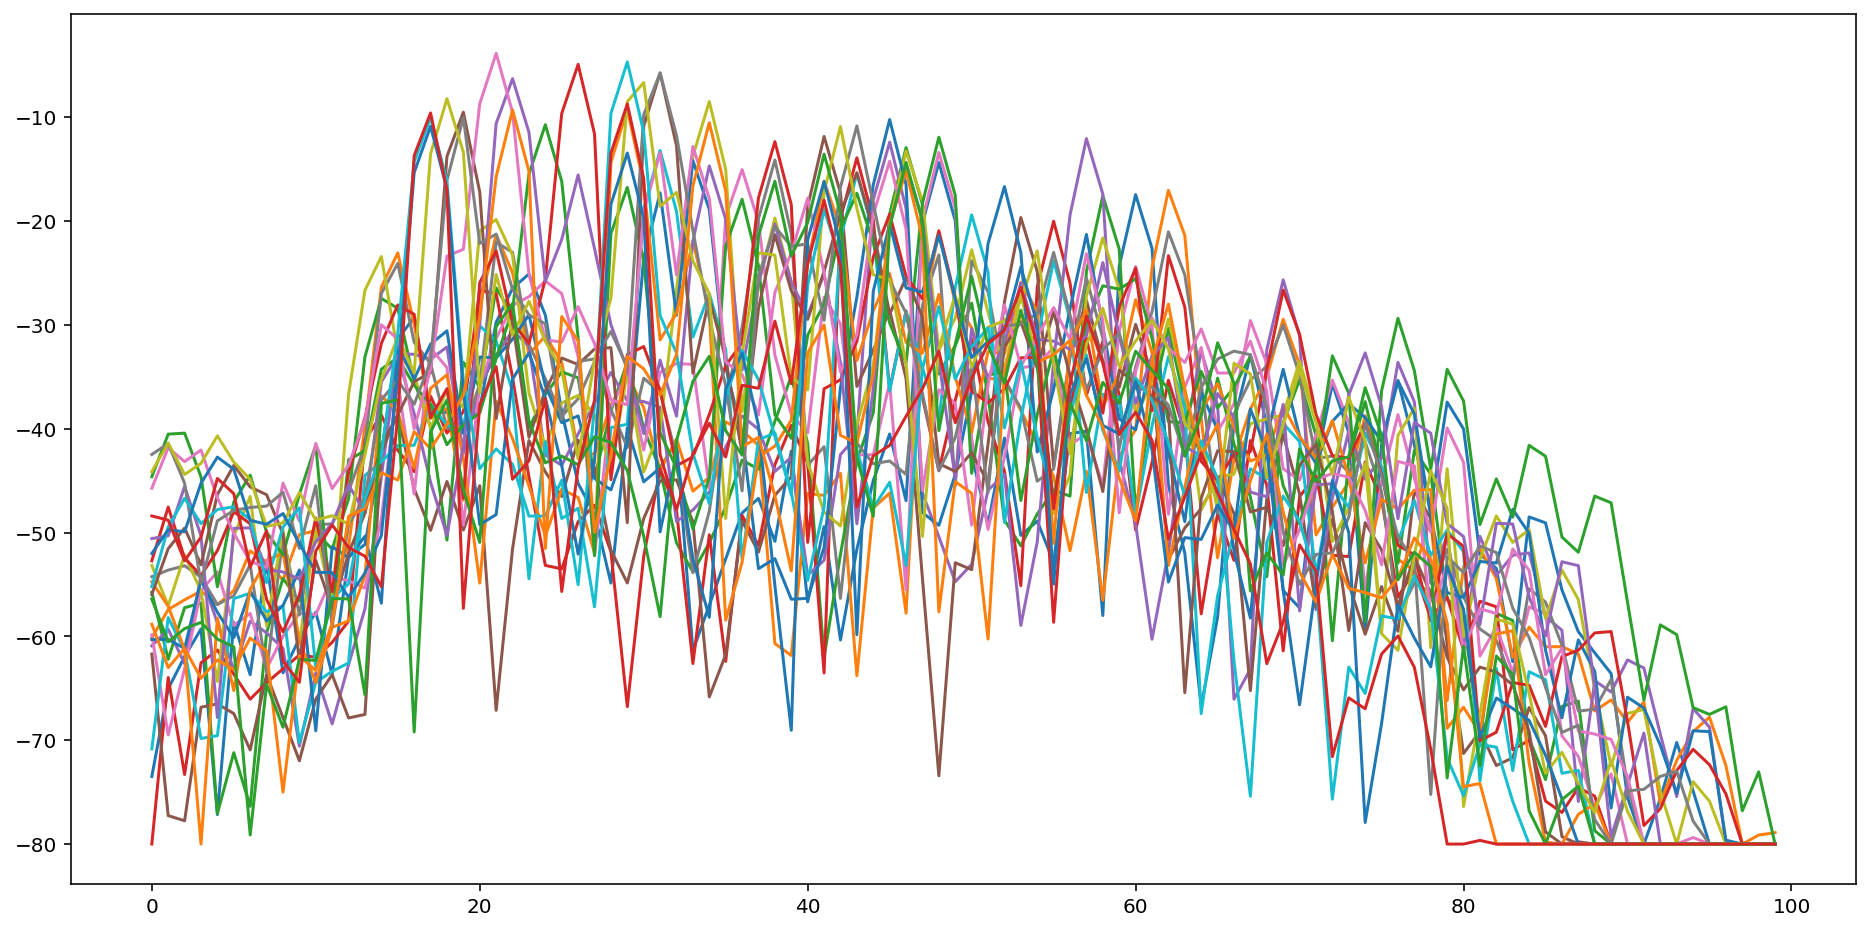

In [23]:
notes = []
note_lengths = []
for i in range(len(onset_frames) - 1):
    frame = middle_onset_frames[i]
    dbs = Cdb[:, frame]
    freq_ind = get_valid_freqs(dbs)[0]
    #freq_ind = np.argmax(dbs)
    freq = freqs[freq_ind]
    plt.plot(dbs)
    #plt.plot((abs(dbs) - np.min(abs(dbs))) / np.max(abs(dbs)))
    note = get_note(freq)
    notes.append(note)
    note_lengths.append(onset_frames[i + 1] - onset_frames[i])

In [24]:
# How to distinguish multiple notes played vs one note

## Music Notation

- http://bspaans.github.io/python-mingus/doc/wiki/tutorialFluidsynth.html

TODO: Explanation

In [25]:
bpm = librosa.beat.beat_track(y=data, sr=sampling_freq, hop_length=hop_length)[0]
print("BPM:", bpm)
len_of_beat = 60 / bpm  # In seconds
print("Beat length:", len_of_beat)

BPM: 80.35714285714286
Beat length: 0.7466666666666666


In [26]:
def estimate_note_length(note_length, len_of_beat):
    # Try whole note, half note, quarter note, eight note, and sixteenth note
    diffs = np.abs([note_length - len_of_beat * 4, note_length - len_of_beat * 2,
                    note_length - len_of_beat, note_length - len_of_beat / 2,
                    note_length - len_of_beat / 8])
    if np.argmin(diffs) == 0: return 1
    if np.argmin(diffs) == 1: return 2
    if np.argmin(diffs) == 2: return 4
    if np.argmin(diffs) == 3: return 8
    if np.argmin(diffs) == 4: return 16

In [27]:
note_notation_lengths = [estimate_note_length(x, len_of_beat) for x in note_lengths]

In [28]:
def convert_notes_and_lengths_to_abjad(notes, note_notation_lengths):
    assert(len(notes) == len(note_notation_lengths))
    
    def number_to_quotes(number):
        if number >= 3:
            return "'" * (number - 3)
        else:
            return "-" * (-1 * number + 3)

    def note_to_notation(note):
        n = note[0]
        if len(note) > 1 and note[1] == "#": return n + "s"
        if len(note) > 1 and note[1] == "b": return n + "f"
        else: return n

    ret = ""
    for i in range(len(notes)):
        note = notes[i].lower()
        note_len = note_notation_lengths[i]
        ret += note_to_notation(note[:-1]) + number_to_quotes(int(note[-1])) + str(note_len) + " "
    return ret

In [29]:
string = convert_notes_and_lengths_to_abjad(notes, note_notation_lengths)
staff = abjad.Staff(string)
lilypond_file = abjad.LilyPondFile(
    items=[
        r'\include "abjad.ily"',
        """#(set-default-paper-size "a5" 'portrait)""",
        """#(set-global-staff-size 16)""",
        """\header {{
            title = \markup {{ Automatic Transcription of {} }}
        }}""".format(filename.split("/")[-1]),
        """\layout {
            indent = 0
        }""",
        staff,
        
    ],
)
abjad.persist.as_png(lilypond_file, "./scores/score_output.png")

(('./scores/score_output.png',),
 0.009895801544189453,
 2.010021209716797,
 False)

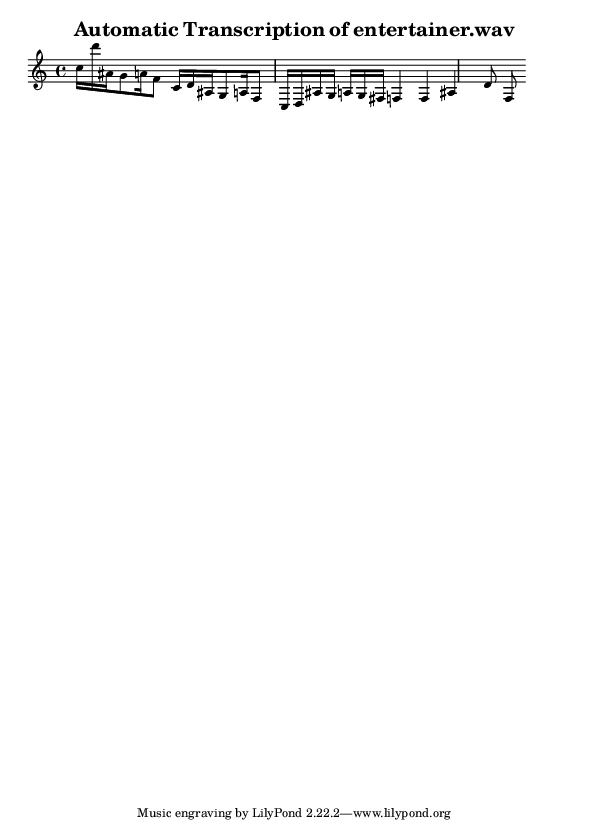

In [30]:
ipd.Image("./scores/score_output.png")

## Play Score

In [31]:
def convert_notes_and_lengths_to_tiny(notes, note_notation_lengths):
    assert(len(notes) == len(note_notation_lengths))
    
    def number_to_quotes(number):
        return "'" * (number - 4)

    def notation(note):
        n = note[0]
        return n

    def accidental(note):
        if len(note) > 1 and note[1] == "#": return "#"
        if len(note) > 1 and note[1] == "b": return "-"
        else: return ""

    ret = ""
    for i in range(len(notes)):
        note = notes[i].lower()
        note_len = note_notation_lengths[i]
        ret += notation(note[:-1]) + number_to_quotes(int(note[-1])) + accidental(note[:-1]) + str(note_len) + " "
    return ret

In [32]:
string = convert_notes_and_lengths_to_tiny(notes, note_notation_lengths)
mm = music21.tempo.MetronomeMark(number=bpm)
stream = music21.stream.Stream()
stream.append(mm)
#stream.repeatAppend(music21.note.Note(quarterLength=1), 2)
#stream.append(music21.converter.parse("tinyNotation: 4/4 {}".format(string)))
for i in range(len(notes)):
    stream.append(music21.note.Note(notes[i], quarterLength=4 / note_notation_lengths[i]))
stream.show("text")

{0.0} <music21.tempo.MetronomeMark andantino Quarter=80.35714285714286>
{0.0} <music21.note.Note C>
{0.25} <music21.note.Note D>
{0.5} <music21.note.Note A#>
{0.75} <music21.note.Note G>
{1.25} <music21.note.Note A>
{1.5} <music21.note.Note F>
{2.0} <music21.note.Note C>
{2.25} <music21.note.Note D>
{2.5} <music21.note.Note A#>
{2.75} <music21.note.Note G>
{3.25} <music21.note.Note A>
{3.5} <music21.note.Note F>
{4.0} <music21.note.Note C>
{4.25} <music21.note.Note D>
{4.5} <music21.note.Note A#>
{4.75} <music21.note.Note G>
{5.25} <music21.note.Note A>
{5.5} <music21.note.Note G>
{5.75} <music21.note.Note F#>
{6.0} <music21.note.Note F>
{7.0} <music21.note.Note F>
{8.0} <music21.note.Note A#>
{8.5} <music21.note.Note D>
{9.0} <music21.note.Note F>


In [33]:
mf = music21.midi.translate.streamToMidiFile(stream)
filename_end = filename.split("/")[-1].split(".")[0]
mf.open('/Users/lucaspauker/Documents/physics_113/final_project/output/{}.mid'.format(filename_end), 'wb')
mf.write()
mf.close()

In [ ]:
sp = music21.midi.realtime.StreamPlayer(stream)
sp.play()

# Polyphonic Music Transcription

NNMF

https://ccrma.stanford.edu/~njb/teaching/sstutorial/part2.pdf
https://www.ee.columbia.edu/~dpwe/e6820/papers/SmarB03-nmf.pdf

In [ ]:
#S = np.abs(librosa.stft(data, n_fft=fft_window_len, hop_length=hop_length, window=scipy.signal.windows.boxcar))
S = np.abs(librosa.cqt(data, sr=sampling_freq, hop_length=hop_length, n_bins=n_bins))
comps, acts = librosa.decompose.decompose(S, n_components=32, sort=True, max_iter=1000)
print("Shape of components matrix:", comps.shape)
print("Shape of activations matrix:", acts.shape)

In [ ]:
plt.plot(comps[:, 10])

In [ ]:
plt.plot(acts[10])

In [ ]:
layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]
fig, ax = plt.subplot_mosaic(layout, constrained_layout=True)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax['A'])
ax['A'].set(title='Input spectrogram')
ax['A'].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max),
                         y_axis='log', ax=ax['B'])
ax['B'].set(title='Components')
ax['B'].label_outer()
ax['B'].sharey(ax['A'])
librosa.display.specshow(acts, x_axis='time', ax=ax['C'], cmap='gray_r')
ax['C'].set(ylabel='Components', title='Activations')
ax['C'].sharex(ax['A'])
ax['C'].label_outer()
S_approx = comps.dot(acts)
img = librosa.display.specshow(librosa.amplitude_to_db(S_approx, ref=np.max),
                               y_axis='log', x_axis='time', ax=ax['D'])
ax['D'].set(title='Reconstructed spectrogram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])
ax['D'].label_outer()
fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")
plt.show()

In [ ]:
# Get frequencies for the components matrix
#freqs = librosa.fft_frequencies(sr=sampling_freq, n_fft=fft_window_len)
freqs = librosa.cqt_frequencies(fmin=librosa.note_to_hz("C1"), n_bins=n_bins)
comp_freqs = []
for i in range(comps.shape[1]):
    comp_freqs.append(freqs[np.argmax(comps[:, i])])
comp_notes = [get_note(x) for x in comp_freqs]

In [ ]:
print(comp_notes)

In [ ]:
plt.plot(acts[10])

In [ ]:
n_voices = 2

In [ ]:
np.argpartition(acts[:, frame], -1 * n_voices)[-1 * n_voices:]

In [ ]:
thresh = 90
notes = []
for frame in middle_onset_frames[:-1]:
    print(comp_notes[np.argmax(acts[:, frame])])
    plt.plot(acts[:, frame])
    #print(acts[:, frame][acts[:, frame] > thresh])
    #print(acts[:, frame])
    #print(np.array(comp_notes)[np.argpartition(acts[:, frame], -1 * n_voices)[-1 * n_voices:]])
    notes.append(np.array(comp_notes)[np.sort(np.argpartition(acts[:, frame], -1 * n_voices)[-1 * n_voices:])])
    print(notes[-1])
    print()
notes = np.array(notes)

In [ ]:
string_1 = convert_notes_and_lengths_to_abjad(notes[:, 0], note_notation_lengths)
string_2 = convert_notes_and_lengths_to_abjad(notes[:, 1], note_notation_lengths)
voice_1 = abjad.Voice(string_1, name="Voice_1")
voice_2 = abjad.Voice(string_2, name="Voice_2")
staff_1 = abjad.Staff(string_1, name="Staff_1")
staff_2 = abjad.Staff(string_2, name="Staff_2")
piano_staff = abjad.StaffGroup(
    [staff_1, staff_2],
    lilypond_type="PianoStaff",
    name="PianoStaff",
)
lilypond_file = abjad.LilyPondFile(
    items=[
        r'\include "abjad.ily"',
        """#(set-default-paper-size "a5" 'portrait)""",
        """#(set-global-staff-size 16)""",
        """\header {{
            title = \markup {{ Automatic Transcription of {} }}
        }}""".format(filename.split("/")[-1]),
        """\layout {
            indent = 0
        }""",
        piano_staff,
        
    ],
)
abjad.persist.as_png(lilypond_file, "./scores/score_output.png")

In [ ]:
ipd.Image("./scores/score_output.png")

In [ ]:
#string_1 = convert_notes_and_lengths_to_tiny(notes[:, 0], note_notation_lengths)
#string_2 = convert_notes_and_lengths_to_tiny(notes[:, 1], note_notation_lengths)
mm = music21.tempo.MetronomeMark(number=bpm)
stream = music21.stream.Stream()
stream.append(mm)
#stream.repeatAppend(music21.note.Note(quarterLength=1), 2)
#stream.append(music21.converter.parse("tinyNotation: 4/4 {}".format(string)))
for i in range(len(notes)):
    c = music21.chord.Chord(" ".join(notes[i]), quarterLength=4 / note_notation_lengths[i])
    stream.append(c)
stream.show("text")

In [ ]:
sp = music21.midi.realtime.StreamPlayer(stream)
sp.play()

## OLD

In [ ]:
onset_frames = filter_onset_frames(onset_frames)

In [ ]:
f, t, Zxx = stft(data, sampling_freq, window="hann", nperseg=fft_window_len)
fig, ax = plt.subplots()
img = plt.pcolormesh(t, np.log10(np.abs(f), where=f>0), np.abs(Zxx), shading="auto")
plt.title('STFT Magnitude')
plt.ylabel('Log Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([np.log10(librosa.note_to_hz('B2')), np.log10(librosa.note_to_hz('B6'))])
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

In [ ]:
f, t, Zxx = stft(data, sampling_freq, window="boxcar", nperseg=fft_window_len)
plt.pcolormesh(t, np.log10(np.abs(f), where=f>0), np.abs(Zxx), shading="auto")
plt.title('STFT Magnitude')
plt.ylabel('Log Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([np.log10(librosa.note_to_hz('B2')), np.log10(librosa.note_to_hz('B6'))])
plt.show()

I should use this:
- https://www.clear.rice.edu/elec301/Projects01/beat_sync/beatalgo.html
- https://www.academia.edu/12988479/Tempo_and_beat_estimation_of_musical_signals

In [ ]:
n = int(4e5)
def get_seconds(num_samples : int) -> float:
    return num_samples / sampling_freq
def list_to_seconds(l): return [get_seconds(x) for x in l]
plt.plot(list_to_seconds(range(len(data[:n]))), data[:n])
plt.title("Original signal")
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
found_nums = False
i = 0
while True:
    if data[i] > 0: break
    i += 1
print("start index:", i)
start_index = i

In [ ]:
n = int(4 / ts)  # One second sample
print(n, "samples")
trimmed_data = data[start_index: start_index + n]
print(data[start_index: start_index + 10])

In [ ]:
fft_out = np.abs(fft(trimmed_data))
freqs = fftfreq(n, ts)
fft_out_side = fft_out[:int(n/2)]
freqs_side = freqs[:int(n/2)]
fft_out[:10]

In [ ]:
plt.plot(range(len(trimmed_data)), fft_out, "r")
plt.title("Signal over time")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
plt.plot(freqs, fft_out, "g")
plt.xlim([-5000, 5000])
plt.title("Full spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count dbl-sided")
plt.show()

In [ ]:
plt.plot(freqs_side, fft_out_side, "b")
plt.xlim([0, 5000])
plt.title("Positive spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count single-sided")
plt.show()

In [ ]:
COUNT_CONST = 5e5
assert(len(fft_out_side) == len(freqs_side))
common_freqs = []
notes = set()


In [ ]:
n = np.argmax(fft_out_side[1:]) + 1
pitch(freqs_side[n])

In [ ]:
#for i in range(1, len(fft_out_side)):
#    count = fft_out_side[i]
#    freq = freqs_side[i]
#    if count > COUNT_CONST:
#        print(freq, count)
#        common_freqs.append(freq)
#        notes.add(pitch(freq))

In [ ]:
def get_beat_length(data, ts):
    return 1.5  # In seconds

In [ ]:
def get_notes(f, beat_length, start_time, end_time):
    pass

In [ ]:
beat_length = get_beat_length(filename)
start_time = 0  # In seconds
end_time = 2
get_notes(filename, beat_length, start_time, end_time)

In [ ]:
ts

In [ ]:
# Find what note this corresponds to using a table
# Copied from https://www.johndcook.com/blog/2016/02/10/musical-pitch-notation/
from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

FREQUENCY_RANGE = (27.5, 4186)
    
def get_note(freq):
    if freq > FREQUENCY_RANGE[1] or freq < FREQUENCY_RANGE[0]: return None
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [ ]:
4 / period

In [ ]:
start_index

In [ ]:
plt.plot(range(len(trimmed_data)), trimmed_data)

In [ ]:
filename = "./sound_files/entertainer.wav"
sampling_freq, data = wavfile.read(filename)
if len(data.shape) == 2:
    data = data.sum(axis=1) / 2
period = 1.0 / sampling_freq  # time between samples in seconds

i = 0
while True:
    if data[i] > 0: break
    i += 1
start_index = i
n = int(0.5 / period)  # how long the sample is
trimmed_data = data[start_index : start_index + n]

WINDOW = 5000
window_frequencies = []

for i in range(len(trimmed_data) - WINDOW):
    print(i)
    sample_data = trimmed_data[i : i + WINDOW]
    fft_out = np.abs(fft(sample_data))[:int(WINDOW/2)]
    freqs = fftfreq(WINDOW, period)[:int(WINDOW/2)]
    window_frequencies.append(freqs[np.argmax(fft_out)])
window_frequencies = window_frequencies + [0] * WINDOW 

In [ ]:
window_notes = [get_note(x) for x in window_frequencies]
set(window_notes)

In [ ]:
plt.plot(range(len(window_frequencies)), window_frequencies)
plt.grid()
plt.show()

In [ ]:
len(trimmed_data)

In [ ]:
window_notes